In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_models import LinearBinaryClassifier, LinearOneVsAllClassifier
from noise_functions_multiclass import tryRegionOneVsAll
%matplotlib inline

In [2]:
folders = ['randomAscent', 'greedyAscent', 'gradientDescent']

In [4]:
loss_histories = []
max_acc_histories = []

for folder in folders:
    lh = np.load('multiclass_experiments/multiclass-'+folder+"-1-17/loss_history.npy")
    loss_histories.append(lh)
    ma = np.load('multiclass_experiments/multiclass-'+folder+"-1-17/max_acc_history.npy")
    max_acc_histories.append(ma)

lh = np.load('multiclass_experiments/multiclass-gradientNonConvex-1-19/loss_history.npy')
loss_histories.append(lh)
ma = np.load('multiclass_experiments/multiclass-gradientNonConvex-1-19/max_acc_history.npy')
max_acc_histories.append(ma)

In [5]:
data_path = "multiclass_data_2"
models = []
exp_type = "multiclass"
num_classifiers = 5
alpha = .5

X_exp = np.load(data_path + "/" + "X_exp.npy")
Y_exp = np.load(data_path + "/" + "Y_exp.npy")

for i in xrange(num_classifiers):
    weights = np.load(data_path + "/" + "weights_{}.npy".format(i))
    bias = np.load(data_path + "/" + "bias_{}.npy".format(i))
    model = LinearOneVsAllClassifier(10, weights, bias)
    models.append(model)

In [6]:
ensemble_weights = sum([1.0 / num_classifiers * model.weights for model in models ])
ensemble_bias = sum([1.0 / num_classifiers * model.bias for model in models ])

In [7]:
ensemble_model = LinearOneVsAllClassifier(10, ensemble_weights, ensemble_bias)

In [8]:
ensemble_model.evaluate(X_exp, Y_exp)

1.0

In [9]:
def optNoiseMulti(model, X, Y):
    n = X.shape[0]
    noise = []
    for i in xrange(n):
        label_options = range(10)
        del label_options[Y[i]]
        v_options = []
        for j in label_options:
            v = tryRegionOneVsAll([model], [j], X[i])
            norm = np.linalg.norm(v)
            v_options.append((norm, v))
        min_v = min(v_options, key=lambda x:x[0])
        if min_v[0] < alpha:
            res = min_v[1]
        else:
            res = np.zeros(28*28)
        noise.append(res)
    return noise

In [10]:
noise = optNoiseMulti(ensemble_model, X_exp, Y_exp)

In [11]:
ensemble_res = max([model.evaluate(X_exp + noise, Y_exp) for model in models])

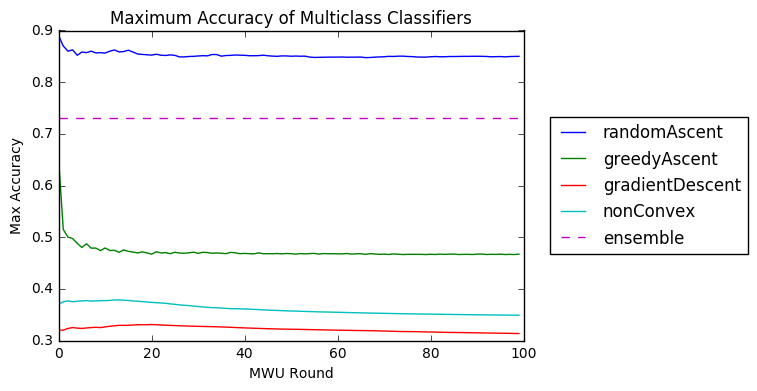

In [12]:
for ma in max_acc_histories:
    plt.plot(range(100), ma)
plt.plot(range(100), [ensemble_res] * 100, linestyle="--")
plt.legend(folders + ["nonConvex", "ensemble"], loc="right", bbox_to_anchor=(1.5,.5))
plt.title("Maximum Accuracy of Multiclass Classifiers")
plt.ylabel("Max Accuracy")
plt.xlabel("MWU Round")